# Classification of Synthesis Parameters using word2vec
Approach: Get 
### Current problem and solution: 
KeyError Words not in library: pass the word


In [1]:
import numpy as np
from gensim.models import Word2Vec
import pickle
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd

### Load trained weights and preprocess data

In [2]:
model = Word2Vec.load("./materials-word-embeddings/bin/word2vec_embeddings-SNAPSHOT.model")
model.hs = 1
model.negative = 0

In [3]:
with open('total_data.pkl','rb') as f:
    total_data = pickle.load(f)

In [4]:
new_model = model.wv

In [5]:
new_model.word_vec("QDs").shape

(100,)

In [6]:
def doc2vec(list_):
    # get average vector for a paragraph
    new = np.zeros((100,))
    count = 0
    for word in list_:
        try:
            #new = np.minimum(new,new_model.word_vec(word))
            new = np.maximum(new,new_model.word_vec(word))
            #np.add(new,new_model.word_vec(word))
            count += 1
        except:
            continue
    return new/count
    #return new

In [7]:
list_x = []
list_y = []
dataset = []
for key in total_data.keys():
    # fitting paper into tfidf vector
    for paragraph in total_data[key]:
        if paragraph[-1] == 1:
            dataset.append(doc2vec(paragraph[0].split()))
            if paragraph[-2] is False:
                list_y.append(0)
            else:
                list_y.append(1)

/home/duc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [8]:
arr = np.asarray(dataset)
y_train = np.asarray(list_y)
len_train = int(len(y_train)*0.9)
X, X_test = arr[:len_train], arr[len_train:]
y, Y_test = y_train[:len_train], y_train[len_train:]
print(X.shape)
print(y.shape)

(2731, 100)
(2731,)


In [9]:
#replace Nan with 0 and inf with finite
X = np.nan_to_num(X)

In [10]:
def over_sampler(X,y):
    count = np.sum(y)
    idxx = np.argwhere(y==1)[:,0]
    new_idxx = np.random.choice(idxx, np.sum(y==0)- np.sum(y))
    X_0 = np.concatenate([X, X[new_idxx]],axis=0)
    y_0 = np.concatenate([y, y[new_idxx]])
    return X_0, y_0

In [11]:
def under_sampler(X,y):
    idx_0 = np.argwhere(y==0)[:,0]
    idx_1 = np.argwhere(y==1)[:,0]
    new_idxx = np.random.choice(idx_0, np.sum(y==1))
    y_0 = y[new_idxx]
    X_0 = X[new_idxx]
    y_1 = y[idx_1]
    X_1 = X[idx_1]
    return np.concatenate([X_0,X_1],axis=0), np.concatenate([y_0,y_1],axis=-1)

In [40]:
X_train, Y_train = over_sampler(X, y)
#X_train, Y_train = under_sampler(X, y)
print(X_train.shape)
print(Y_train.shape)

(4862, 100)
(4862,)


## Tensorflow

In [41]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
    ])
model.compile(loss= 'sparse_categorical_crossentropy', optimizer= 'Adam' , metrics=['accuracy'])
model.fit(X_train, Y_train, epochs = 100)

Train on 4862 samples
Epoch 1/100
4862/4862 [==============================] - 0s 67us/sample - loss: 0.6061 - acc: 0.6421
Epoch 2/100
4862/4862 [==============================] - 0s 54us/sample - loss: 0.5495 - acc: 0.6907
Epoch 3/100
4862/4862 [==============================] - 0s 58us/sample - loss: 0.5267 - acc: 0.7168
Epoch 4/100
4862/4862 [==============================] - 0s 58us/sample - loss: 0.5079 - acc: 0.7244
Epoch 5/100
4862/4862 [==============================] - 0s 56us/sample - loss: 0.4971 - acc: 0.7322
Epoch 6/100
4862/4862 [==============================] - 0s 61us/sample - loss: 0.4876 - acc: 0.7413
Epoch 7/100
4862/4862 [==============================] - 0s 63us/sample - loss: 0.4821 - acc: 0.7454
Epoch 8/100
4862/4862 [==============================] - 0s 58us/sample - loss: 0.4657 - acc: 0.7587
Epoch 9/100
4862/4862 [==============================] - 0s 56us/sample - loss: 0.4536 - acc: 0.7684
Epoch 10/100
4862/4862 [==============================] - 0s 53us/sam

4862/4862 [==============================] - 0s 70us/sample - loss: 0.1772 - acc: 0.9362
Epoch 82/100
4862/4862 [==============================] - 0s 46us/sample - loss: 0.1727 - acc: 0.9389
Epoch 83/100
4862/4862 [==============================] - 0s 47us/sample - loss: 0.1606 - acc: 0.9443
Epoch 84/100
4862/4862 [==============================] - 0s 44us/sample - loss: 0.1594 - acc: 0.9399
Epoch 85/100
4862/4862 [==============================] - 0s 46us/sample - loss: 0.1587 - acc: 0.9451
Epoch 86/100
4862/4862 [==============================] - 0s 47us/sample - loss: 0.1552 - acc: 0.9469
Epoch 87/100
4862/4862 [==============================] - 0s 45us/sample - loss: 0.1596 - acc: 0.9404
Epoch 88/100
4862/4862 [==============================] - 0s 45us/sample - loss: 0.1504 - acc: 0.9494
Epoch 89/100
4862/4862 [==============================] - 0s 45us/sample - loss: 0.1543 - acc: 0.9461
Epoch 90/100
4862/4862 [==============================] - 0s 46us/sample - loss: 0.1491 - acc: 

## Random Forrest

In [14]:
#model = LogisticRegression()
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier()

### F-1 Score and Confusion Matrix

In [36]:
X_test = np.nan_to_num(X_test)

In [37]:
def binarialize(vector) ->int:
    if vector[0] < vector[1]:
        return 1
    return 0

In [38]:
Y_pred = model.predict(X_test)
new_Y_pred = []
for vector in Y_pred:
    new_Y_pred.append(binarialize(vector))
Y_pred = np.array(new_Y_pred)

0.23376623376623376
[[168 116]
 [  2  18]]


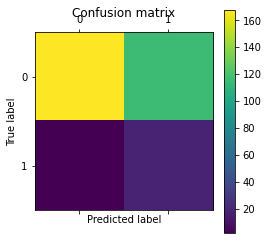

In [39]:
print(f1_score(Y_test, Y_pred))
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()